# Water Potability Data Exploration Notebook

In [1]:
import sys
sys.path.append('/home/jovyan/work')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession, Window, DataFrame
from pyspark.mllib.stat import Statistics

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

21/07/26 17:36:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/07/26 17:36:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load the Dataset

In [3]:
df = spark.read.csv('../data/water_potability.csv',inferSchema=True, header=True)

In [4]:
print('Total record count: {}'.format(df.count()))

Total record count: 3276


In [5]:
# Show a Sample
df.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|             null| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862|              null| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089|              n

## Exploratory Data Analysis

In [6]:
# Show the Schema and Check Types
df.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



In [7]:
# Check for Missing Data
df.select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



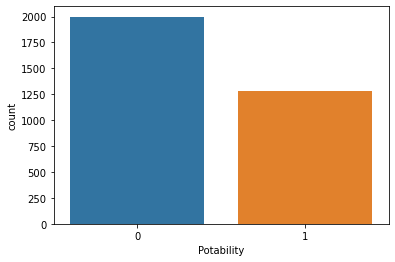

In [8]:
# Distribution of Target Column
df_pandas = df.toPandas()
sns.countplot(x=df_pandas['Potability']);

In [9]:
# View Summary Statistics
df_pandas.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


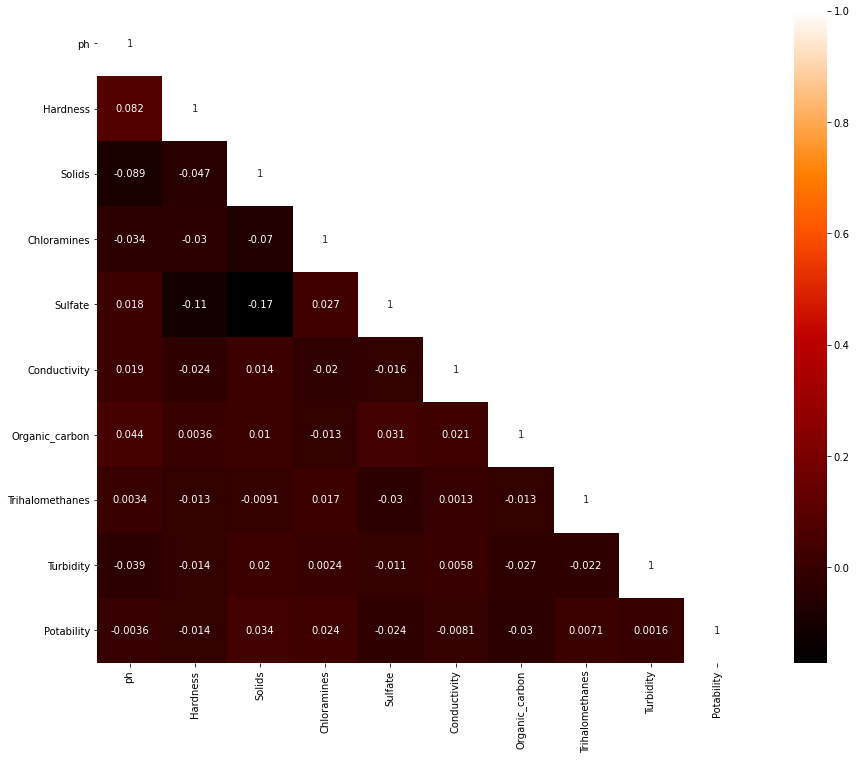

In [10]:
# Correlation matrix for dataset
corrs = df_pandas.corr()
mask = np.array(corrs)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(16, 12)
sns.heatmap(corrs, mask=mask, square=True, annot=True, cbar=True, cmap="gist_heat");

The correlation matrix shows very weak correlation among the features. This suggests they are somewhat independent of each other. There doesn't seem to be any multicollinearity, and most feature are negatively correlated with potability.

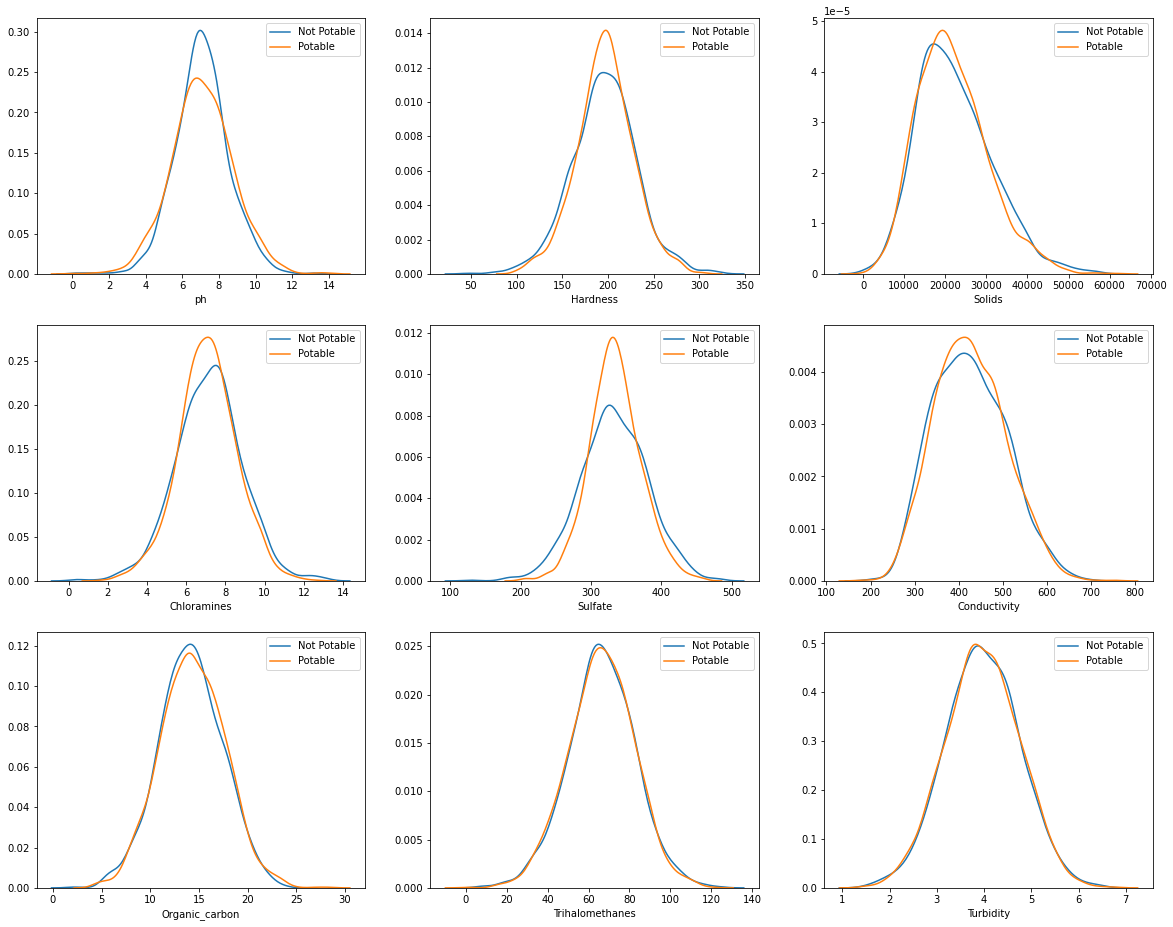

In [11]:
# Feature value distribution
potable = df_pandas.query('Potability == 0')
not_potable = df_pandas.query('Potability == 1')

fig = plt.figure(figsize=(20,16))
num_rows = 3
num_cols = 3

for ax,column in enumerate(df_pandas.columns[:df_pandas.shape[1] - 1]):
    plt.subplot(num_rows, num_cols, ax+1)
    sns.kdeplot(x=not_potable[column],label='Not Potable')
    sns.kdeplot(x=potable[column],label='Potable')
    plt.legend(prop=dict(size=df_pandas.shape[1]))
    plt.ylabel('')